In [14]:
import pandas as pd
import os

In [15]:
# train_data.csv 불러오기
df = pd.read_csv("/opt/ml/input/data/FE_total_data.csv")
df.head(2)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,dataset
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1


In [16]:
# 문항별 정답현황 list로 가져오기
groupby_problem = df.groupby("assessmentItemID")["answerCode"].apply(list)
groupby_problem[:3]

assessmentItemID
A010001001    [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...
A010001002    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
A010001003    [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, ...
Name: answerCode, dtype: object

In [17]:
# 문제별로 맞은 사람 수, 틀린 사람수, 정답률 계산
correction = list() # [[문제ID, 맞은사람수, 틀린사람수, 정답률], ...]
for problem, correctness in zip(groupby_problem.index, groupby_problem):
    correction.append([problem, sum(correctness), len(correctness) - sum(correctness), round(sum(correctness) / len(correctness), 3)])

# 위에서 생성한 list를 이용해서 dataframe을 생성
problem_df = pd.DataFrame(data=correction, columns=["problemId", "correctCnt", "incorrectCnt", "correctRatio"])
problem_df.head(3)

,problemId,correctCnt,incorrectCnt,correctRatio
0,A010001001,323,27,0.923
1,A010001002,336,14,0.960
2,A010001003,317,33,0.906


In [18]:
# 급 EDA
problem_df['allCnt']=problem_df['correctCnt']+problem_df['incorrectCnt'] #allCnt는 Eda만을 위한 column
print(problem_df.mean())
print("한 문제 번호당 최대로 풀린 횟수",max(problem_df['allCnt']))
print("한 문제 번호당 최소로 풀린 횟수",min(problem_df['allCnt']))
problem_df.head()

correctCnt      174.830125
incorrectCnt     92.432410
correctRatio      0.653951
allCnt          267.262534
dtype: float64
한 문제 번호당 최대로 풀린 횟수 500
한 문제 번호당 최소로 풀린 횟수 50


/tmp/ipykernel_2747/1582649488.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(problem_df.mean())


,problemId,correctCnt,incorrectCnt,correctRatio,allCnt
0,A010001001,323,27,0.923,350
1,A010001002,336,14,0.960,350
2,A010001003,317,33,0.906,350
3,A010001004,331,19,0.946,350
4,A010001005,309,41,0.883,350


In [19]:
problem_df.set_index('problemId',inplace=True)
problem_df.head(3)

,correctCnt,incorrectCnt,correctRatio,allCnt
problemId,,,,
A010001001,323,27,0.923,350
A010001002,336,14,0.960,350
A010001003,317,33,0.906,350


In [20]:
relative=list()
for problem_id, ac in zip(df.assessmentItemID,df.answerCode): # 30초 소요
    relative.append(round(ac-problem_df.loc[problem_id, 'correctRatio'],3))
relative[:5]

[0.016, 0.032, 0.084, 0.028, 0.052]

In [21]:
df['relativeAnswerCode']=relative
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,dataset,relativeAnswerCode
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,0.016
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,0.032
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1,0.084
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1,0.028
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1,0.052


## 결과 확인

<AxesSubplot:>

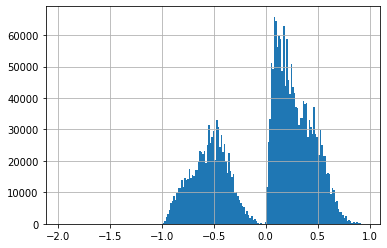

In [22]:
df['relativeAnswerCode'].hist(bins=200)

맞은 문제이지만 난이도가 높은 것은 많고, 틀린문제이지만 난이도가 쉬운 문제는 적다

## 저장

In [23]:
os.makedirs('/opt/ml/input/data/FE/', exist_ok=True)
df.to_csv('/opt/ml/input/data/FE/relativeAnswerCode.csv', index=False)